In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numba

%matplotlib inline

Much of the code here is built off of documentation found here: http://ballistipedia.com/index.php?title=Range_Statistics#Example:_NRA.27s_Test_Protocol

Further the implementation is heavily inspired by the following associated c code: http://ballistipedia.com/images/6/64/ES_Quantiles.c

3.663837977460026 3.5399907757553635


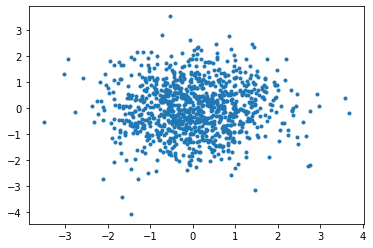

In [21]:
x, y = np.random.default_rng().multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000).T
print(np.max(x), np.max(y))
plt.plot(x,y, '.')

In [100]:
def shoot(n):
    '''
        Produces x, y coordinates for each shot aiming at 0,0 and with a std of 0 in both axes
          n: Number of shots
    '''
    x, y = np.random.default_rng().multivariate_normal([0, 0], [[1, 0], [0, 1]], n).T
    return x, y

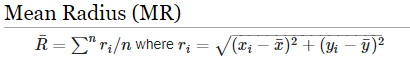

In [3]:
def calc_mean_radius(group_x, group_y):
    assert group_x.shape == group_y.shape, 'X and Y must be the same length'
    return np.sum( np.sqrt( (group_x - group_x.mean())**2 + (group_y - group_y.mean())**2 ) / group_x.shape[0])

# Vary the # of groups

In [4]:
def sim_sessions(num_iter, num_groups, num_shots, std=False):
    '''
        simulates shooting sessions with a specified num groups, and num of shots per group
        
        num_iter: the number of iterations to simulate
        num_groups: The number of groups per 'session'
        num_shots: the number of shots in each group
        
        returns the mean radius of each session
    '''
    if std is False:
        radii = np.zeros(num_iter)
    else:
        radii = np.zeros([num_iter, 2])
    for i in range(num_iter):
        group = np.zeros(num_groups)
        for j in range(num_groups):
            group[j] = calc_mean_radius(*shoot(num_shots))
        if std is False:
            radii[i] = np.mean(group)
        else:
            radii[i] = (np.mean(group), np.std(group))
        
    return radii

In [197]:
cis = []
for i in np.arange(2,21):
    cis.append( np.quantile(sim_sessions(10000, 5, i), [0.25, 0.5, 0.75]) )
cis = np.array(cis)

([<matplotlib.axis.XTick at 0x2046ab81288>,
 <a list of 10 Text xticklabel objects>)

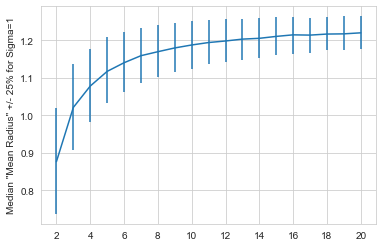

In [204]:
# error bars capture 50% of points
plt.errorbar(np.arange(2,21), cis[:,1], [cis[:,1]-cis[:,0], cis[:,2]-cis[:,1]])
plt.ylabel('Median "Mean Radius" +/- 25% for Sigma=1')
plt.xticks(np.arange(2,21, 2))

# Groups of groups
How do smaller group sizes affect STD?

In [257]:
results = {'ix':[], 'mean':[], 'std':[]}
for shots in range(2, 11):
    runs = []
    for i in range(10000):
        # 15 is close to the sample size for an interaction effect with 5 samples per exp group
        runs.append(sim_sessions(1, 15, shots, std=True)[0])
    runs = np.array(runs)
    results['ix'].append(shots)
    results['mean'].append(runs[:,0].mean())
    results['std'].append(runs[:,1].mean())
    print( shots )

2
3
4
5
6
7
8
9
10


In [259]:
df = pd.DataFrame(results).set_index('ix')

In [6]:
df

,mean,std
2,0.886642,0.439112
3,1.022762,0.354837
4,1.086002,0.307836
5,1.120682,0.275788
6,1.143295,0.252276
7,1.160387,0.233312
8,1.171798,0.218038
9,1.181095,0.206474
10,1.189265,0.195916


Text(0.5, 1.0, 'Mean & std dev by # of shots per group\nSimulated for sigma=1, N of 15')

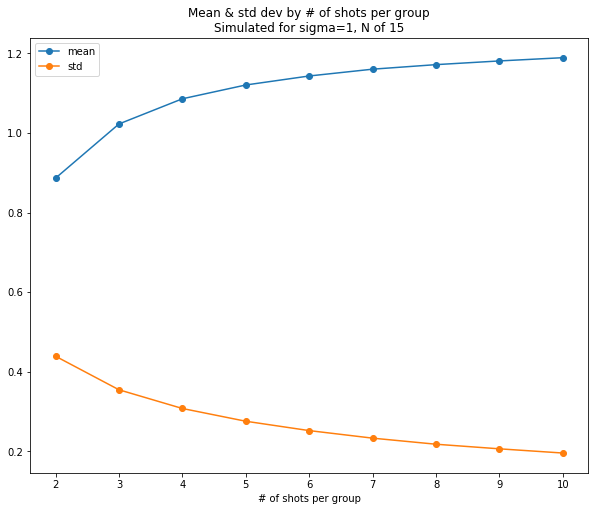

In [8]:
df.plot.line(style='-o', figsize=(10,8), )
plt.xlabel('# of shots per group')
plt.title('Mean & std dev by # of shots per group\nSimulated for sigma=1, N of 15')

# Effect of group size on CI width (t test for simplicity)

In [41]:
def gen_experiment_t(num_of_trials, num_shots):
    '''
    Simulates running a full size experiment with a given number of groups and shots per condition under the null.
    '''
    r = np.zeros(num_of_trials)
    for i in range(num_of_trials):
            r[i] =  calc_mean_radius(*shoot(num_shots))
    return r.mean()

In [61]:
cis = {'n':[], 'shots':[], 'ci_width':[]}
for n in [15, 30]:
    for shots in range(2,11):
        result = list()
        for i in range(10000):
             result.append( gen_experiment_t(n, shots) )
        a, b = np.quantile(result, [0.025, 0.975])
        cis['ci_width'].append( b - a )
        cis['shots'].append(shots)
        cis['n'].append(n)
        print(shots)

2
3
4
5
6
7
8
9
10
2
3
4
5
6
7
8
9
10


In [64]:
df = pd.DataFrame(cis).set_index('shots')

In [66]:
df

,n,ci_width
shots,,
2,15,0.469328
3,15,0.376293
4,15,0.330087
5,15,0.295701
6,15,0.268193
7,15,0.244750
8,15,0.235483
9,15,0.221655
10,15,0.209677


(0, 0.5)

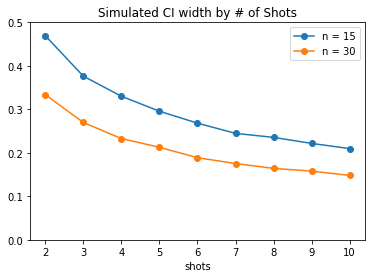

In [77]:
df.query('n==15')['ci_width'].plot.line(label='n = 15', style='o-', legend=True)
df.query('n==30')['ci_width'].plot.line(label='n = 30', style='o-', legend=True)
plt.title('Simulated CI width by # of Shots')
plt.ylim([0, 0.5])

In [78]:
(0.269730-0.212769) / 0.269730

0.21117784451117788

In [79]:
(0.376293-0.295701) / 0.376293

0.21417352966969888

At both sample sizes increasing from 3 shot to 5 shot groups decreases the width of the confidence interval by 20%, meaning it will be substantially easier to detect an effect.

After 6 shots the benefits are very small, and don't appear to be worthwhile.

# ANOVA Simulation
Note: I haven't found a good use for this simulation yet. It should be pretty easy to pull expected minimum detectable effect sizes for the main effects. Interactions are much more challenging to quantify.

### References:

https://www.statsmodels.org/stable/examples/notebooks/generated/interactions_anova.html

https://pythonfordatascience.org/anova-2-way-n-way/

In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [97]:
conds = [
    {'a':1, 'b':1,'c':1},
    {'a':1, 'b':1,'c':0},
    {'a':1, 'b':0,'c':0},
    {'a':1, 'b':0,'c':1},
    {'a':0, 'b':1,'c':1},
    {'a':0, 'b':0,'c':1},
    {'a':0, 'b':1,'c':0},
    {'a':0, 'b':0,'c':0},
]

In [98]:
def gen_experiment(num_of_groups, conds, num_shots):
    '''
    Simulates running a full size experiment with a given number of groups and shots per condition under the null.
    '''
    result = []
    for cond in conds:
        for j in range(num_of_groups):
            r = cond.copy()
            r['MR'] =  calc_mean_radius(*shoot(num_shots))
            result.append(r)
    return pd.DataFrame(result)

In [99]:
# simulate running the experiment 10,000 times with a specific set of conditions
results = []
for i in range(10000):
    results.append(gen_experiment(5, conds, 5))

In [ ]:
# Take a look at an example run

In [93]:
model = ols('MR ~ C(a)*C(b)*C(c)', results[17]).fit()

In [94]:
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 7, 32) =  0.678, p =  0.6892


In [140]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MR   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.403
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.238
Time:                        17:10:48   Log-Likelihood:                 2.1407
No. Observations:                  40   AIC:                             11.72
Df Residuals:                      32   BIC:                             25.23
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.1463      0.115      9.996      0.000       0.913       1.380
C(a)[T.1]                        -0.3107      0.162     -1.916      0.064      -0.641       0.020
C(b)[T.1]                        -0.0105      0.162     -0.065      0.949      -0.341       0.320
C(c)[T.1]                        -0.1261      0.162     -0.777      0.443      -0.456       0.204
C(a)[T.1]:C(b)[T.1]               0.3294      0.229      1.436      0.161      -0.138       0.797
C(a)[T.1]:C(c)[T.1]               0.2252      0.229      0.982      0.334      -0.242       0.692
C(b)[T.1]:C(c)[T.1]               0.0458      0.229      0.200      0.843      -0.421       0.513
C(a)[T.1]:C(b)[T.1]:C(c)[T.1]    -0.0398      0.324     -0.123      0.903      -0.700       0.621
==============================================================================
Omnibus:                        0.946   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.462
Skew:                          -0.257   Prob(JB):                        0.794
Kurtosis:                       3.112   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.stats.anova_lm(model)

In [173]:
def test_results(r):
    '''
        Identify the specific values that would be significant for the main effect of A
    '''
    sig = []
    for result in r:
        model = ols('MR ~ C(a)+C(b)+C(c)', result).fit()
        anova_p = sm.stats.anova_lm(model).loc['C(a)', 'PR(>F)']
        if anova_p < 0.1:
            sig.append(result)
            
    return sig

In [148]:
sig = test_results(results)